In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

In [13]:
sample = pd.read_excel('C:/Users/Марина/Desktop/sample_1.xlsx')

In [14]:
sample.head()

,sale_date,contact_id,sum_disc
0,2023-09-08,52093,-3307.96
1,2023-09-13,30216,-1599.00
2,2023-08-17,6627,-1569.99
3,2023-09-13,9799,-1220.01
4,2023-08-30,69480,-1139.97


##### В колонке sum_disc есть минусовые значения,вероятно это возвраты.
##### Их и позиции с нулевыми значениями считать я не буду, поэтому удалю их из датасета

In [15]:
sample.query("sum_disc<0")

,sale_date,contact_id,sum_disc
0,2023-09-08,52093,-3307.96
1,2023-09-13,30216,-1599.00
2,2023-08-17,6627,-1569.99
3,2023-09-13,9799,-1220.01
4,2023-08-30,69480,-1139.97
...,...,...,...
122,2023-10-04,17415,-40.02
123,2023-08-31,70114,-28.03
124,2023-09-28,49904,-24.02
125,2023-10-08,56626,-13.83


In [16]:
condition = (sample['sum_disc'] < 0)

In [17]:
sample = sample.drop(sample[condition].index)

In [18]:
sample.shape[0]

1046728

In [19]:
sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1046728 entries, 127 to 1046854
Data columns (total 3 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   sale_date   1046728 non-null  datetime64[ns]
 1   contact_id  1046728 non-null  int64         
 2   sum_disc    1046728 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 24.0 MB


##### Вижу что содержание колонок соответсвует типу данных

In [20]:
sample['sale_date'].describe()

C:\Users\Марина\AppData\Local\Temp\ipykernel_8940\3969654445.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  sample['sale_date'].describe()


count                 1046728
unique                     83
top       2023-08-02 00:00:00
freq                    14885
first     2023-08-02 00:00:00
last      2023-10-23 00:00:00
Name: sale_date, dtype: object

##### Данные в таблице за неполных три месяца
##### Первая дата покупки была 02 августа 2023 года, а последняя 23 октября 2023
##### Обозначу дату последней покупки, она нам пригодится для дальнейшего анализа

In [21]:
last_date = sample['sale_date'].max()

##### Вычислю , сколько прошло дней с момента последней покупки last_date, у клиента -- Recency
##### количество покупок для каждого клиента за все время -- Frequency
##### сумму всех покупок клиента (LTV) -- Monetary

##### Cгруппирую датасет для каждого клиента и посчитаю все нужные для RFM анализа показатели

In [22]:
rfm_table = sample.groupby('contact_id').agg({'sale_date': lambda x: (last_date - x.max()).days, # Recency -- Количество дней с последнего заказа
                                        'contact_id': lambda x: len(x),      # Frequency -- Количество заказов
                                        'sum_disc': lambda x: x.sum()}, as_index = False) # Monetary Value -- Общая сумма по всем заказам

rfm_table['sale_date'] = rfm_table['sale_date'].astype(int)
rfm_table.rename(columns={'sale_date': 'recency', 
                         'contact_id': 'frequency', 
                         'sum_disc': 'monetary_value'}, inplace=True)

In [23]:
rfm_table.head()

,recency,frequency,monetary_value
contact_id,,,
-1,0,72,1.546815e+09
1167,4,33,3.262766e+04
1168,2,2,1.932120e+03
1170,47,3,5.336390e+03
1171,8,19,5.769522e+04


In [24]:
rfm_table.shape[0]

58769

In [25]:
sample['contact_id'].nunique()

58769

##### Далее разделю все распределения на ровные 4 части (используя квантили (0.25%)),
##### для того чтобы присвоить каждому уникальному клиенту определенный класс

In [26]:
quantiles = rfm_table.quantile(q = [0.25, 0.5, 0.75, 0.95])

In [27]:
quantiles

,recency,frequency,monetary_value
0.25,1.0,7.0,4238.800
0.50,3.0,14.0,10436.020
0.75,10.0,26.0,21071.600
0.95,47.0,46.0,45849.396


##### В recency чем ниже квантиль , чем выше класс.
##### 0.25 -- 1 класс, активные
##### 0.5 -- 2 класс, лояльные
##### 0.75 -- 3 класс, спящие
##### 0.95 -- 4 класс, отвалившиеся

##### А в frequency и monetary_value логика обратная, чем выше квантиль, тем выше и класс
##### 0.95 -- 1 класс, активные
##### 0.75 -- 2 класс, лояльные
##### 0.5 -- 3 класс, спящие
##### 0.25 -- 4 класс, отвалившиеся

##### Напишу для этого распределения функцию

In [28]:
rfm_segmentation = rfm_table

In [29]:
def R_class(value,parameter_name,quantiles_table):
    if value <= quantiles_table[parameter_name][0.25]:
        return 1
    elif value <= quantiles_table[parameter_name][0.50]:
        return 2
    elif value <= quantiles_table[parameter_name][0.75]: 
        return 3
    else:
        return 4


def FM_class(value, parameter_name,quantiles_table):
    if value <= quantiles_table[parameter_name][0.25]:
        return 4
    elif value <= quantiles_table[parameter_name][0.50]:
        return 3
    elif value <= quantiles_table[parameter_name][0.75]: 
        return 2
    else:
        return 1

In [30]:
rfm_segmentation['R_Quartile'] = rfm_segmentation['recency'].apply(R_class, args=('recency',quantiles))

rfm_segmentation['F_Quartile'] = rfm_segmentation['frequency'].apply(FM_class, args=('frequency',quantiles))

rfm_segmentation['M_Quartile'] = rfm_segmentation['monetary_value'].apply(FM_class, args=('monetary_value',quantiles))

rfm_segmentation['RFM_class'] = rfm_segmentation.R_Quartile.map(str) \
                              + rfm_segmentation.F_Quartile.map(str) \
                              + rfm_segmentation.M_Quartile.map(str)

In [31]:
rfm_segmentation.head()

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFM_class
contact_id,,,,,,,
-1,0,72,1.546815e+09,1,1,1,111
1167,4,33,3.262766e+04,3,1,1,311
1168,2,2,1.932120e+03,2,4,4,244
1170,47,3,5.336390e+03,4,4,3,443
1171,8,19,5.769522e+04,3,2,1,321


##### Создам график seaborn с RF табличкой и посмотрю как распределились клиенты
##### В ячейках укажу медианное значение LTV в сегменте

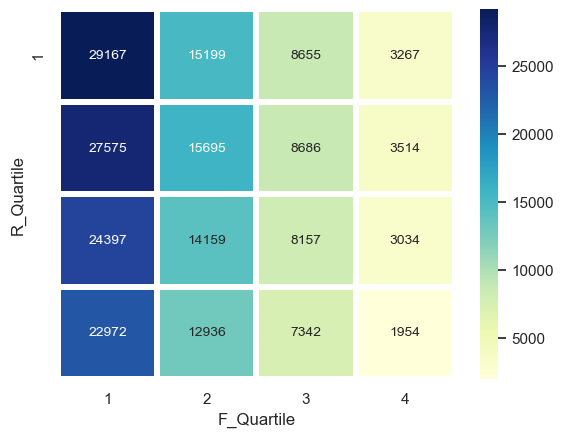

In [32]:
RFM = rfm_segmentation.pivot_table(
                        index='R_Quartile', 
                        columns='F_Quartile', 
                        values='monetary_value', 
                        aggfunc=np.median).applymap(int)
sns.heatmap(RFM, cmap="YlGnBu", annot=True, fmt=".0f", linewidths=4.15, annot_kws={"size": 10},yticklabels=4);

In [35]:
rfm_segmentation['RFM_class'].value_counts().sort_values(ascending = False)

444    8094
111    6381
122    2548
344    2392
211    2376
       ... 
413      11
141      11
114       6
314       4
214       3
Name: RFM_class, Length: 63, dtype: int64

##### Анализ показал, что у нас большинство клиентов в группе 444, то есть 8094 клиента отвалившиеся.
##### 6381 клиент в группе 111 -- активные.

##### Для повышения прибыли и эффективности маркетинга
##### следует сосредоточить усилия на сегментах с высокими показателями (111, 122)
##### и стратегически подходить к сегментам с низкой активностью (444),
##### возможно, применяя персонализированные подходы для их вовлечения.